In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
%cd ..
%ls

/home/mahdigilany/offline_codes/codes/ts_snr
configs/     logs/    notebooks/  README.md         scripts/     src/
darts_logs/  main.py  OLD/        requirements.txt  slurm_logs/  wandb/


In [2]:
i_th_run = 0
exp_name = f"test_deeptime_calculate_metrics"
main_dir = f"logs/experiments/runs/{exp_name}"
main_dir = os.path.join(os.getcwd(), main_dir)
work_dir = glob(os.path.join(main_dir, "**/darts_logs"), recursive=True)
config_dir = glob(os.path.join(main_dir, "**/config.yaml"), recursive=True)
config_dir = [dir for dir in config_dir if "wandb" not in dir]
work_dir = work_dir[i_th_run]
config_dir = config_dir[i_th_run]
config_dir

'/home/mahdigilany/offline_codes/codes/ts_snr/logs/experiments/runs/test_deeptime_calculate_metrics/2023-06-09_14-51-29/config.yaml'

In [3]:
from omegaconf import OmegaConf
from src.driver.drivers import inference_darts_lightning_driver_run

config = OmegaConf.load(config_dir)
config.logger = None
model, data, metrics = inference_darts_lightning_driver_run(config)

In [4]:
train, val, test, scaler = data.train_series, data.val_series, data.test_series, data.scaler
model.load_weights_from_checkpoint(config.model.model_name, work_dir=work_dir) # don't use load_from_checkpoint since needs logger and produces error

In [5]:
from darts.timeseries import concatenate 
from darts.utils.data.sequential_dataset import PastCovariatesSequentialDataset


horizon = 96
lookback = 672
val_test_series_trimmed = concatenate([val[-lookback:], test])
# test_ds = model._build_train_dataset(val_test_series_trimmed, past_covariates=None, future_covariates=None, max_samples_per_ts=None)
test_ds = PastCovariatesSequentialDataset(val_test_series_trimmed, input_chunk_length=lookback, output_chunk_length=horizon, covariates=None, use_static_covariates=False)
from torch.utils.data import DataLoader
from tqdm import tqdm
test_dl = DataLoader(
    test_ds,
    batch_size=model.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
    collate_fn=model._batch_collate_fn,
    )

pl_model = model.model 
pl_model.eval()
preds = []
targets = []
for batch in tqdm(test_dl, desc="evaluating on test set"):
    input_series, _, _, target_series = batch
    input_series = input_series.to(device=pl_model.device, dtype=pl_model.dtype)
    target_series = target_series.to(device=pl_model.device, dtype=pl_model.dtype)
    pred = pl_model((input_series, _))
    preds.append(pred.detach().cpu())
    targets.append(target_series.detach().cpu())
preds = torch.cat(preds, dim=0)
targets = torch.cat(targets, dim=0)

preds = preds.flip(dims=[0])
targets = targets.flip(dims=[0])

evaluating on test set: 100%|██████████| 106/106 [00:04<00:00, 26.49it/s]


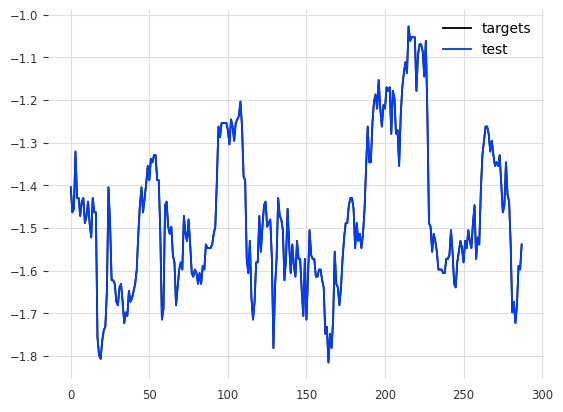

In [34]:
component = 6
n = 96*3
which_th = 95
plt.plot(range(len(targets[:n,which_th,component])), targets[:n,which_th,component], label="targets")
# plt.plot(range(len(preds[:n,which_th,component,0])), preds[:n,which_th,component,0], label="preds")
# plt.plot(range(len(targets[-n:,which_th+1,component])), targets[-n:,which_th+5,component], label="targets")
plt.plot(range(len(test._xa.values[:n,component,0])), test._xa.values[which_th:n+which_th,component,0], label="test")
plt.legend()

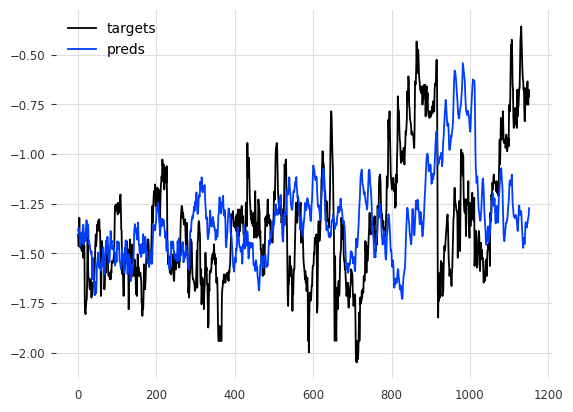

In [30]:
component = 6
n = 96*12
which_th = 95
plt.plot(range(len(targets[:n,which_th,component])), targets[:n,which_th,component], label="targets")
plt.plot(range(len(preds[:n,which_th,component,0])), preds[:n,which_th,component,0], label="preds")
# plt.plot(range(len(targets[-n:,which_th+1,component])), targets[-n:,which_th+5,component], label="targets")
# plt.plot(range(len(test._xa.values[:n,component,0])), test._xa.values[which_th:n+which_th,component,0], label="test")
plt.legend()

## Auto correlation and cross correlation

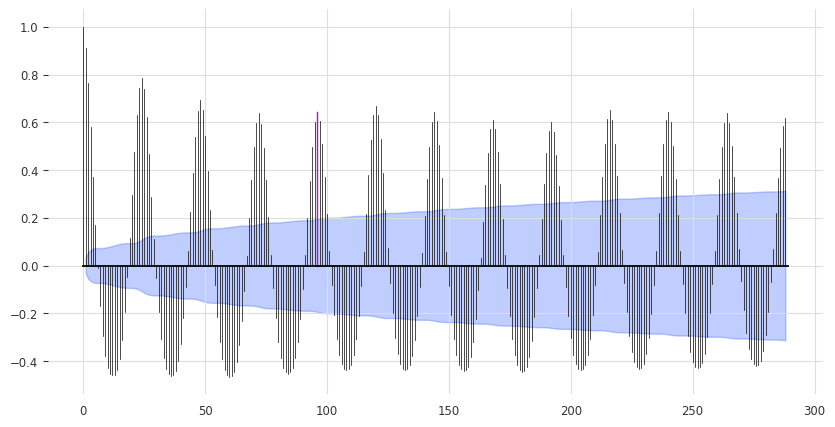

In [99]:
from darts.utils.statistics import plot_acf, check_seasonality
from statsmodels.tsa.stattools import acf, ccf

component = 6
n = 96*12
which_th = 95

target_values = targets[:,which_th,component]
preds_values = preds[:,which_th,component,0]

plot_acf(test['HUFL'], m=96, alpha=0.05, max_lag=96*3)

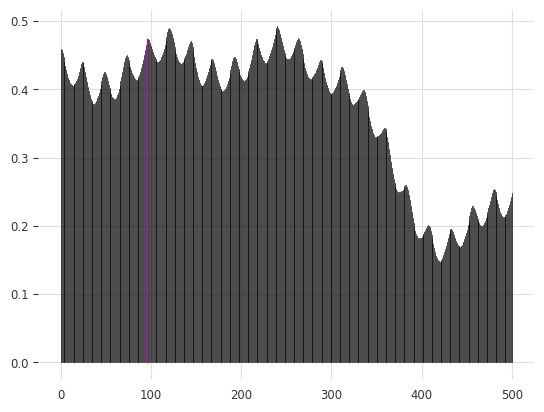

In [100]:
cross_correlation = ccf(target_values, preds_values, adjusted=False, fft=False)
m=96*1
nlags=500
for i in range(len(cross_correlation)):
    if i>nlags:
        break
    plt.plot(
        (i, i),
        (0, cross_correlation[i]),
        color=("#b512b8" if m is not None and i == m else "black")
        if True
        else None,
        lw=(1 if m is not None and i == m else 0.5),
    )

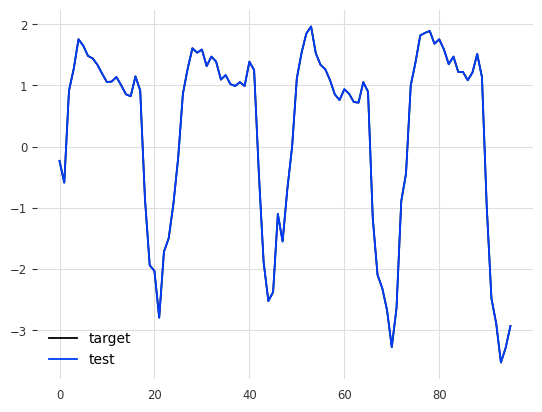

In [280]:
batch = test_ds[3389]
input_series, _, _, target_series = batch
input_series = torch.tensor(input_series).to(device=pl_model.device, dtype=pl_model.dtype)
pred = pl_model((input_series.reshape(1,input_series.shape[0],input_series.shape[1]), _))
pred = pred.detach().cpu().numpy()
component=0
pred = pred[:,:,component,:].flatten()
target_series = target_series[:,component].flatten()

n=96
plt.plot(range(len(target_series[:])), target_series[:], label="target")
# plt.plot(range(len(pred[:])), pred[:], label="pred")
plt.plot(range(len(test._xa.values[:n])), test._xa.values[:n,component,0], label="test")
plt.legend()

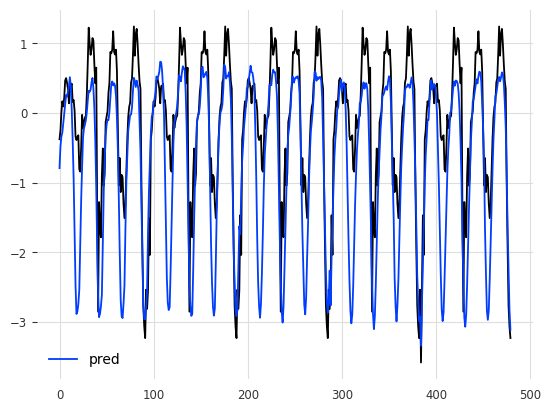

In [283]:
batch = next(iter(test_dl))
input_series, _, _, target_series = batch
pred = pl_model((input_series, _))
pred = pred.detach().cpu().numpy()
target_series = target_series.detach().cpu().numpy()
component=2
pred = pred[:,:,component,0].flatten()
target_series = target_series[:,:,component].flatten()
pred.shape
n=96*5
plt.plot(range(len(target_series[-n:])), target_series[-n:])
plt.plot(range(len(pred[-n:])), pred[-n:], label="pred")
plt.legend()

In [285]:

list_backtest_series = []
for i in range(preds.shape[0]):
    backtest_series = TimeSeries.from_times_and_values(val_test_series_trimmed.time_index[lookback+i:lookback+i+horizon], preds[i,...].detach().cpu().numpy(), freq=val_test_series_trimmed.freq)
    list_backtest_series.append(backtest_series)

In [288]:
from darts.timeseries import concatenate 
# list_backtest_unscaled_series = [scaler.inverse_transform(backtest_series) for backtest_series in list_backtest_series]
backtest_series = concatenate([backtest_series[-1] for backtest_series in list_backtest_series])


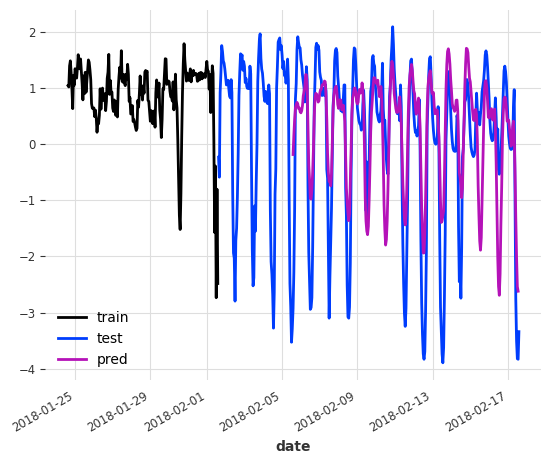

In [301]:
comp = 'HUFL'
val[comp][-2*horizon:].plot(label="train")
test[comp][:4*horizon].plot(label="test")
backtest_series['0'][:3*horizon].plot(label="pred")
# list_backtest_series[0]['0'].plot(label="pred")
# list_backtest_series[150]['6'].plot(label="pred")